# Auto-Encoder Example

Build a 2 layers auto-encoder with TensorFlow v2 to compress images to a lower latent space and then reconstruct them.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## Auto-Encoder Overview

<img src="autoenc.jpg"/>

References:
- [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Proceedings of the IEEE, 86(11):2278-2324, November 1998.

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

In this example, each image will be converted to float32, normalized to [0, 1] and flattened to a 1-D array of 784 features (28*28).

<img src='mnist_100_digits.png'/>

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from mylib.mylib import *

In [2]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.01
training_steps = 20000
batch_size = 256
display_step = 1000

# Network Parameters
num_hidden_1 = 128 # 1st layer num features.
num_hidden_2 = 64 # 2nd layer num features (the latent dim).

In [544]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [580]:
toAddNoise=False
nNoise=80
noiselevel=1

def addnoise(img, nNoise=50, lNoise=0.75):
    inoise=np.array(np.random.uniform(0,len(img), nNoise), dtype='int32')
    noise=np.zeros(len(img))
    noise[inoise]=np.random.uniform(0,lNoise, nNoise)
    highlight=max(img)
    img+=noise
    img[img>=highlight]=highlight
    return img

if toAddNoise:
    for i in range(x_train.shape[0]): 
        x_train[i]= addnoise(x_train[i], nNoise=nNoise, lNoise=noiselevel)
    for i in range(x_test.shape[0]): 
        x_test[i]= addnoise(x_test[i], nNoise=nNoise, lNoise=noiselevel)

In [572]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [573]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    'encoder_h1': tf.Variable(random_normal([num_features, num_hidden_1])),
    'encoder_h2': tf.Variable(random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(random_normal([num_hidden_1, num_features])),
}
biases = {
    'encoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(random_normal([num_features])),
}

In [574]:
# Building the encoder.
def encoder(x):
    # Encoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),  biases['encoder_b2']))
    return layer_2


# Building the decoder.
def decoder(x):
    # Decoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),  biases['decoder_b2']))
    return layer_2

In [575]:
# Mean square loss between original images and reconstructed ones.
def mean_square(reconstructed, original):
    return tf.reduce_mean(tf.pow(original - reconstructed, 2))

# Adam optimizer.
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [2]:
printsource(tf.optimizers.Adam)

class Adam(optimizer_v2.OptimizerV2):
  """Optimizer that implements the Adam algorithm.

  Adam optimization is a stochastic gradient descent method that is based on
  adaptive estimation of first-order and second-order moments.
  According to the paper
  [Adam: A Method for Stochastic Optimization. Kingma et al.,
  2014](http://arxiv.org/abs/1412.6980),
   the method is "*computationally efficient, has little memory
  requirement, invariant to diagonal rescaling of gradients, and is well suited
  for problems that are large in terms of data/parameters*".

  For AMSGrad see [On The Convergence Of Adam And Beyond.
  Reddi et al., 5-8](https://openreview.net/pdf?id=ryQu7f-RZ).
  """

  def __init__(self,
               learning_rate=0.001,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-7,
               amsgrad=False,
               name='Adam',
               **kwargs):
    r"""Construct a new Adam optimizer.

    If amsgrad = False:
      Initializat

In [576]:
encoded=None
# Optimization process. 
def run_optimization(x):
    # Wrap computation inside a GradientTape for automatic differentiation.
    global encoded
    with tf.GradientTape() as g:
        encoded=encoder(x)
        reconstructed_image = decoder(encoded)
        loss = mean_square(reconstructed_image, x)

    # Variables to update, i.e. trainable variables.
    trainable_variables =[]
    for e in weights.values(): trainable_variables.append(e)
    for e in biases.values(): trainable_variables.append(e)
    
    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss

In [577]:
# Run training for the given number of steps.
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
    
    # Run the optimization.
    loss = run_optimization(batch_x)
    
    if step % display_step == 0:
        print("step: %i, loss: %f" % (step, loss))

step: 0, loss: 0.222904
step: 1000, loss: 0.067323
step: 2000, loss: 0.059700
step: 3000, loss: 0.059901
step: 4000, loss: 0.054940
step: 5000, loss: 0.054848
step: 6000, loss: 0.052736
step: 7000, loss: 0.052821
step: 8000, loss: 0.051069
step: 9000, loss: 0.051585
step: 10000, loss: 0.050370
step: 11000, loss: 0.048897
step: 12000, loss: 0.049267
step: 13000, loss: 0.048426
step: 14000, loss: 0.049435
step: 15000, loss: 0.048100
step: 16000, loss: 0.047595
step: 17000, loss: 0.046812
step: 18000, loss: 0.047089
step: 19000, loss: 0.046963
step: 20000, loss: 0.048204


In [43]:
# Testing and Visualization.
import matplotlib.pyplot as plt

In [52]:
encoded[0]

<tf.Tensor: id=6241390, shape=(64,), dtype=float32, numpy=
array([0.35039836, 0.64059365, 0.6506891 , 0.77703285, 0.6988108 ,
       0.44274613, 0.7295214 , 0.5447508 , 0.6411592 , 0.39813226,
       0.26360315, 0.24064797, 0.5561793 , 0.41302475, 0.5555492 ,
       0.3261299 , 0.2944312 , 0.6142504 , 0.4688037 , 0.4872271 ,
       0.6759832 , 0.5826526 , 0.6275346 , 0.4965006 , 0.4088572 ,
       0.3502072 , 0.5375295 , 0.39188355, 0.5555493 , 0.52183795,
       0.40540463, 0.5305181 , 0.37147596, 0.60182977, 0.4358002 ,
       0.48628783, 0.25686076, 0.4702018 , 0.36288548, 0.52322954,
       0.4270181 , 0.3356216 , 0.64692026, 0.3860362 , 0.39701512,
       0.5562107 , 0.61603045, 0.4491235 , 0.64569896, 0.29933977,
       0.753277  , 0.23578739, 0.37568903, 0.5467408 , 0.46583155,
       0.31730655, 0.44949728, 0.30002165, 0.5412673 , 0.5159764 ,
       0.33068556, 0.44696563, 0.42707914, 0.21000999], dtype=float32)>

In [55]:
i=0

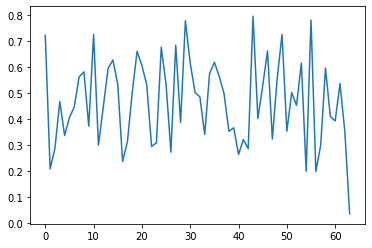

In [91]:
plt.plot(encoded[i]);i+=1

Original Images


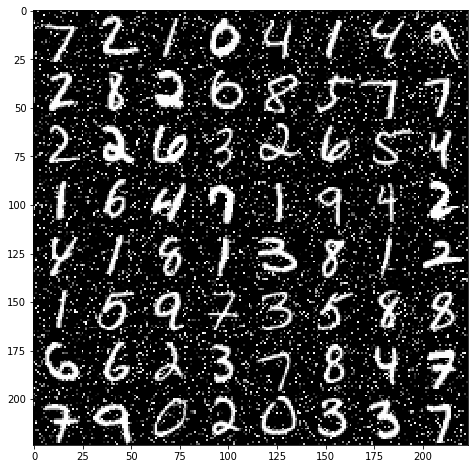

Reconstructed Images


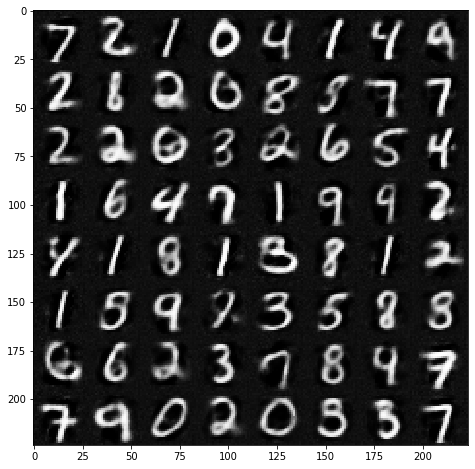

In [578]:
# Encode and decode images from test set and visualize their reconstruction.
n = 8
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i, (batch_x, _) in enumerate(test_data.take(n)):
    # Encode and decode the digit image.
    reconstructed_images = decoder(encoder(batch_x))
    # Display original images.
    for j in range(n):
        # Draw the generated digits.
        img = batch_x[j].numpy().reshape([28, 28])
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
    # Display reconstructed images.
    for j in range(n):
        # Draw the generated digits.
        reconstr_img = reconstructed_images[j].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstr_img

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

In [96]:
i=0

1.0


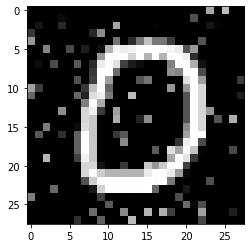

In [530]:
# Display image and model prediction.
nn=28*28
inoise=np.array(np.random.uniform(0,nn, 100), dtype='int32')
noise=np.zeros(nn)
noise[inoise]=np.random.uniform(0,0.75, 100)
highlight=max(img)
img=x_test[i]+noise
print(highlight)
img[img>=highlight]=highlight
plt.imshow(np.reshape(img, [28, 28]), cmap='gray')
plt.show()
i+=1

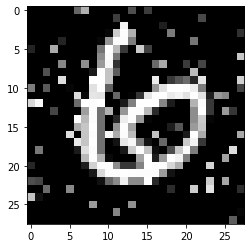

In [570]:
def addnoise(img, nNoise=100, lNoise=0.75):
    inoise=np.array(np.random.uniform(0,len(img), nNoise), dtype='int32')
    noise=np.zeros(len(img))
    noise[inoise]=np.random.uniform(0,lNoise, nNoise)
    highlight=max(img)
    img+=noise
    img[img>=highlight]=highlight
    return img

img=addnoise(x_test[i], nNoise=80, lNoise=1)
plt.imshow(np.reshape(img, [28, 28]), cmap='gray')
plt.show()
i+=1

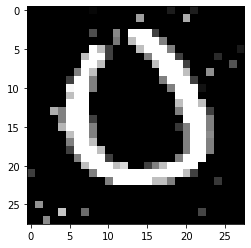

In [557]:
plt.imshow(np.reshape(x_train[i], [28, 28]), cmap='gray')
plt.show()
i+=1

Original Images


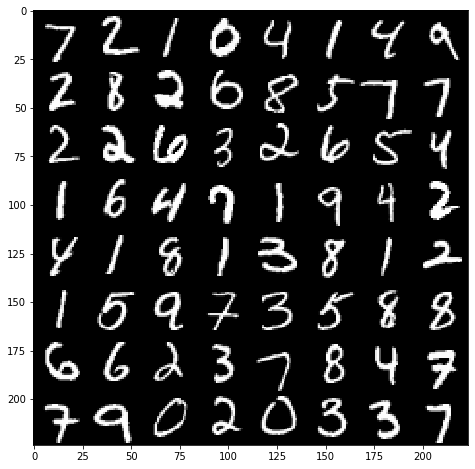

Reconstructed Images


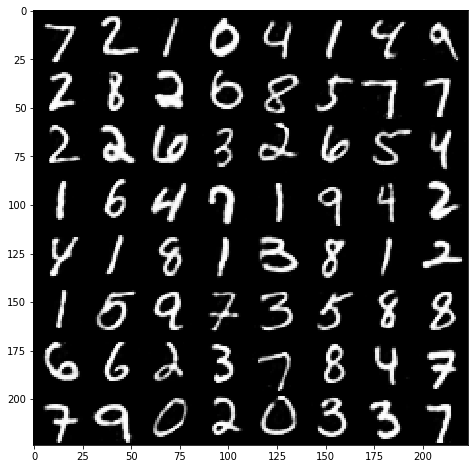

In [543]:
# Encode and decode images from test set and visualize their reconstruction.
n = 8
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i, (batch_x, _) in enumerate(test_data.take(n)):
    # Encode and decode the digit image.
    reconstructed_images = decoder(encoder(batch_x))
    # Display original images.
    for j in range(n):
        # Draw the generated digits.
        img = batch_x[j].numpy().reshape([28, 28])
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
    # Display reconstructed images.
    for j in range(n):
        # Draw the generated digits.
        reconstr_img = reconstructed_images[j].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstr_img

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()